# Dataloader

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
from torch.autograd import Variable
from tqdm.notebook import tqdm

In [2]:
%cd sample_data

/content/sample_data


In [ ]:
# download  datasets 
!wget https://www.dropbox.com/s/0vv2qsc4ywb4z5v/original.tar.gz
!tar zxf original.tar.gz
!wget https://www.dropbox.com/s/u1iekdnwail1d9u/only_bg_b.tar.gz
!tar zxf only_bg_b.tar.gz
!wget https://www.dropbox.com/s/0v6w9k7q7i1ytvr/no_fg.tar.gz
!tar zxf no_fg.tar.gz
!wget https://www.dropbox.com/s/f2525w5aqq67kk0/mixed_same.tar.gz
!tar zxf mixed_same.tar.gz
!wget https://www.dropbox.com/s/cto15ceadgraur2/mixed_rand.tar.gz
!tar zxf mixed_rand.tar.gz
!wget https://www.dropbox.com/s/4hnkbvxastpcgz2/mixed_next.tar.gz
!tar zxf mixed_next.tar.gz 

In [ ]:
%ls

In [4]:
data_dir="original"
bg_b_dir="only_bg_b"
no_fg_dir="no_fg"
mixed_same='mixed_same'
mixed_rand='mixed_rand'
mixed_next='mixed_next'

In [5]:
from torchvision import transforms,datasets
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean=[0.4717, 0.4499, 0.3837], std=[0.2600, 0.2516, 0.2575])
imagenet_format = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor(), normalize])
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), imagenet_format) for x in ['train', 'val']}
bg_b_set={x: datasets.ImageFolder(os.path.join(bg_b_dir, x), imagenet_format) for x in ['train', 'val']}
no_fg_set={x: datasets.ImageFolder(os.path.join(no_fg_dir, x), imagenet_format) for x in ['train', 'val']}
mixed_same_set = {x: datasets.ImageFolder(os.path.join(mixed_same, x), imagenet_format) for x in ['train', 'val']}
mixed_rand_set = {x: datasets.ImageFolder(os.path.join(mixed_rand, x), imagenet_format) for x in ['train', 'val']}
mixed_next_set = {x: datasets.ImageFolder(os.path.join(mixed_next, x), imagenet_format) for x in ['train', 'val']}

In [ ]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_sizes

{'train': 45405, 'val': 4185}

In [ ]:
dset_classes = dsets['train'].classes

In [6]:
# define dataloaders
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)
loader_valid = torch.utils.data.DataLoader(dsets['val'], batch_size=5, shuffle=False, num_workers=6)
loader_bg_b = torch.utils.data.DataLoader(bg_b_set['val'], batch_size=5, shuffle=False, num_workers=6)
loader_no_fg = torch.utils.data.DataLoader(no_fg_set['val'], batch_size=5, shuffle=False, num_workers=6)
loader_mixed_same = torch.utils.data.DataLoader(mixed_same_set['val'], batch_size=5, shuffle=False, num_workers=6)
loader_mixed_rand = torch.utils.data.DataLoader(mixed_rand_set['val'], batch_size=5, shuffle=False, num_workers=6)
loader_mixed_next = torch.utils.data.DataLoader(mixed_next_set['val'], batch_size=5, shuffle=False, num_workers=6)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Test dataloader

In [ ]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4717, 0.4499, 0.3837])
    std = np.array([0.2600, 0.2516, 0.2575])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

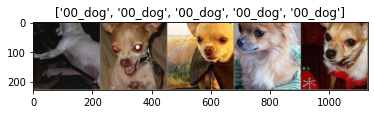

In [ ]:
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


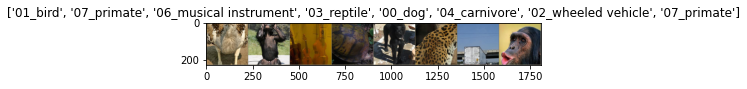

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

# Define Network

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50=model_resnet50.to(device)
model_resnet50.fc = nn.Linear(2048, 9)
model = model_resnet50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# model_mobilenet = models.mobilenet_v3_large(pretrained=True)
# model_mobilenet.classifier[3] = nn.Linear(1280, 9)

# Data Processing

## CutMix

In [15]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [16]:
# generate mixed sample

def mixcut_data(input, y, alpha=1,cutmix_prob=1, use_cuda=True):
    r = np.random.rand(1)
    if r <cutmix_prob:
        lam = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(input.size()[0]).cuda()
        y_a = y
        y_b = y[rand_index]
        bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
        input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
        # adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
        # compute output
        return input, y_a, y_b, lam
def mixcut_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
x, y = iter(loader_train).next()
mixed_x, y_a, y_b, lam = mixcut_data(x, y, use_cuda=False)

In [ ]:
out = torchvision.utils.make_grid(mixed_x[0:2])
imshow(out)

## Mixup

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
x, y = iter(loader_train).next()
mixed_x, y_a, y_b, lam = mixup_data(x, y, use_cuda=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


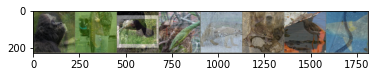

In [ ]:
out = torchvision.utils.make_grid(mixed_x[0:4])
imshow(out)

# Train

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)
n_epochs = 200
alpha = 1

In [ ]:
####################
# If you want to train network on cutmix data,
# you need to change the function mixup_data, mixup_criterion to mixcut_data and mixcut_criterion respectively.
####################
model=model.to(device)
model.train()

loss_train = np.zeros(n_epochs)
acc_train = np.zeros(n_epochs)
for epoch_num in tqdm(range(n_epochs)):
  running_corrects = 0.0
  running_loss = 0.0
  total = 0
  for batch_idx, (inputs, targets) in tqdm(enumerate(loader_train)): 
      if torch.cuda.is_available():
          inputs, targets = inputs.cuda(), targets.cuda()

      inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                      alpha, torch.cuda.is_available())
      inputs, targets_a, targets_b = map(Variable, (inputs,
                                                    targets_a, targets_b))
      outputs = model(inputs)
      loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      running_loss += loss.data.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      running_corrects += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                  + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())
      
  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  loss_train[epoch_num] = epoch_loss
  acc_train[epoch_num] = epoch_acc
  print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [ ]:
########
# Save the model. No need to run this block if you do not save model
########
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), 'drive/MyDrive/ResnetMixcut.pt')

# Test

In [ ]:
#################
# Load the model. No need to run this block if you do not load model
#################
PATH = 'Original.pt'
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

In [14]:
model.eval()
loader = loader_no_fg
model = model.to('cpu')
running_corrects = 0.0
running_loss = 0.0
size = 0
criterion = nn.CrossEntropyLoss()

for data in tqdm(loader):
    inputs, labels = data
    bs = labels.size(0)
    with torch.no_grad():
      output = model(inputs)
      pred = output.max(1, keepdim=True)[1]
      running_corrects += pred.eq(labels.view_as(pred)).sum()
      loss = criterion(output, labels)
      running_loss += loss
      size += bs

print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss.item() / size, running_corrects.item() / size))

  0%|          | 0/837 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test - Loss: 0.7729 Acc: 0.2652


# SWA training

In [ ]:
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)
n_epochs = 200
alpha = 1

swa_model = AveragedModel(model)
scheduler = CosineAnnealingLR(optimizer, T_max=100)
swa_start = int(n_epochs * 0.75)
swa_scheduler = SWALR(optimizer, swa_lr=0.05)

In [ ]:
model.to(device)
model.train()

loss_train = np.zeros(n_epochs)
acc_train = np.zeros(n_epochs)
for epoch_num in tqdm(range(n_epochs)):
  running_corrects = 0.0
  running_loss = 0.0
  total = 0
  for batch_idx, (inputs, targets) in tqdm(enumerate(loader_train)): 
      if torch.cuda.is_available():
          inputs, targets = inputs.cuda(), targets.cuda()

      inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                      alpha, torch.cuda.is_available())
      inputs, targets_a, targets_b = map(Variable, (inputs,
                                                    targets_a, targets_b))
      outputs = model(inputs)
      loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      running_loss += loss.data.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      running_corrects += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                  + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())
      
  if epoch_num > swa_start:
          swa_model.update_parameters(model)
          swa_scheduler.step()
  else:
          scheduler.step()
      
  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  loss_train[epoch_num] = epoch_loss
  acc_train[epoch_num] = epoch_acc
  print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))